In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/JohnsHopkins.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = ld_coord[idx[i],1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_JH', ref_nodes) 
            np.save('results/info_ref_nodes_JH', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 1 Feature value  217.0  gap  [0.76972008]  volume:  10696.0  size: 200 conductance:  0.262341062079282
Reached
Number of feature 2 Feature value  2008.0  gap  [0.86957805]  volume:  82875.0  size: 912 conductance:  0.3928446455505279
Reached
Number of feature 2 Feature value  2009.0  gap  [0.83656915]  volume:  32454.0  size: 886 conductance:  0.19757194798792135


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_JH.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_JH.npy') 

## Visualize the ground truth clusters

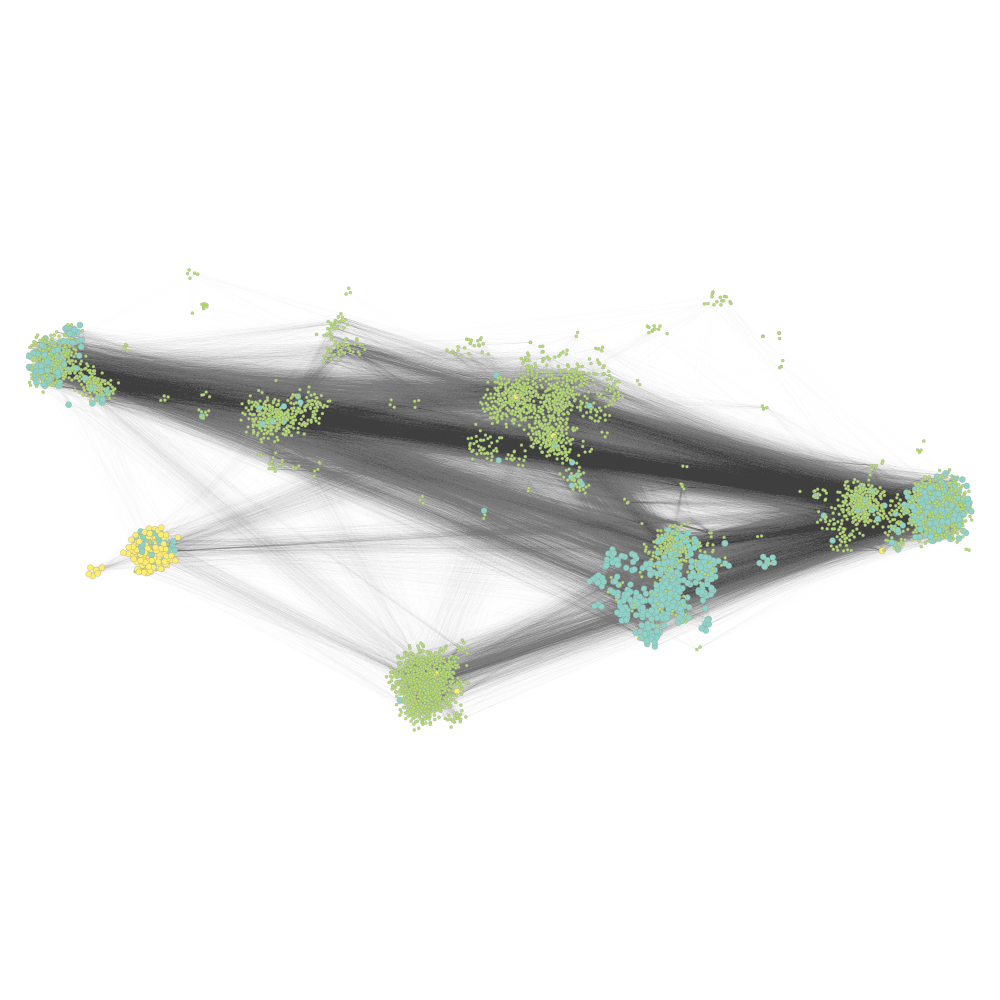

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ae36978, at 0x10b607fd0>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_JH', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_JH', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_JH', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_JH', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_JH', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_JH', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_JH', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_JH', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_JH', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_JH', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_JH', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_JH', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_JH', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_JH', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_JH', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_JH', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_JH', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_JH', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_JH', cuts_acl_ALL) 
    
    np.save('results/nodes_JH', nodes)

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.21284978280634406 f1score:  0.8640932265112892 precision:  0.8988786746135974 recall:  0.8318997756170531
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.1827817032354035 f1score:  0.9436580882352942 precision:  0.9279645697758496 recall:  0.9598915482423336
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.19825935596170582 f1score:  0.9245470116289551 precision:  0.8926022628372497 recall:  0.9588631264023935
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.25797239409804856 f1score:  0.8715131748347781 precision:  0.8054894494685071 recall:  0.9493268511593119
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.2117330362944398 f1score:  0.8901206390609717 precision:  0.8869395711500975 recall:  0.893324607329843
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conducta

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.2006462182579412 f1score:  0.3910767879364615 precision:  0.24312824246837172 recall:  0.9989715781600599
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18881381381381382 f1score:  0.9108331115251531 precision:  0.8666216444369408 recall:  0.9597980553477936
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.1808743169398907 f1score:  0.9412844036697248 precision:  0.9239913544668588 recall:  0.9592370979805535
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.17773391606748437 f1score:  0.3865552474363031 precision:  0.24131520855117927 recall:  0.9709237097980553
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.1986275257338925 f1score:  0.9195454339656812 precision:  0.8914932841717145 recall:  0.9494203440538519
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conducta

outer: 0 number of node:  928  completed:  0.9  degree:  45.0
conductance:  0.21091254424587758 f1score:  0.9117105794694557 precision:  0.8768022101355435 recall:  0.949513836948392
outer: 0 number of node:  1564  completed:  0.91  degree:  34.0
conductance:  0.19572114948780708 f1score:  0.9150826160997836 precision:  0.9011875623243586 recall:  0.9294128646222887
outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.18559416004435408 f1score:  0.3974482963844666 precision:  0.2480729940564636 recall:  0.9989715781600599
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18852698104035 f1score:  0.9200869801576516 precision:  0.8925118650026367 recall:  0.9494203440538519
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.20981991165477404 f1score:  0.9052875200284849 precision:  0.863914373088685 recall:  0.9508227374719521
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  

outer: 1 number of node:  4925  completed:  0.07017543859649122  degree:  186.0
conductance:  0.25775822139879573 f1score:  0.6361806875107964 precision:  0.49538958200221944 recall:  0.8887722473604827
outer: 1 number of node:  37  completed:  0.07236842105263158  degree:  131.0
conductance:  0.2626174350010924 f1score:  0.4720114220725825 precision:  0.35706593052907826 recall:  0.6960965309200603
outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.3335334380309698 f1score:  0.6018855449261826 precision:  0.48790123086610393 recall:  0.7853634992458521
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.26966822104304017 f1score:  0.4686027286841587 precision:  0.3776352308964214 recall:  0.6173031674208145
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.2639325444929573 f1score:  0.5581889299215524 precision:  0.43758393860490613 recall:  0.7705701357

outer: 1 number of node:  961  completed:  0.1600877192982456  degree:  27.0
conductance:  0.3317536053181794 f1score:  0.5250603920753723 precision:  0.3791194658492932 recall:  0.853683257918552
outer: 1 number of node:  1660  completed:  0.16228070175438597  degree:  83.0
conductance:  0.3292337055881107 f1score:  0.6723007965388599 precision:  0.542022923610136 recall:  0.8850196078431373
outer: 1 number of node:  1113  completed:  0.16447368421052633  degree:  24.0
conductance:  0.1872146118721461 f1score:  0.04930662557781201 precision:  0.23036649214659685 recall:  0.027607843137254902
outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.29568177553810276 f1score:  0.6539705353934603 precision:  0.5423122765196663 recall:  0.8235294117647058
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.30817151496306144 f1score:  0.5967983789260385 precision:  0.5143331150403841 recall:  0.71075716440422

outer: 1 number of node:  884  completed:  0.25  degree:  26.0
conductance:  0.2589582920148586 f1score:  0.3968071960546384 precision:  0.28651811838847624 recall:  0.6451402714932126
outer: 1 number of node:  1948  completed:  0.25219298245614036  degree:  206.0
conductance:  0.30788326568691055 f1score:  0.5166750809253704 precision:  0.3731294468363457 recall:  0.8397224736048265
outer: 1 number of node:  3599  completed:  0.2543859649122807  degree:  63.0
conductance:  0.26953305098375596 f1score:  0.4927000501468586 precision:  0.40773061418069717 recall:  0.6224072398190045
outer: 1 number of node:  901  completed:  0.2565789473684211  degree:  140.0
conductance:  0.3285986878778783 f1score:  0.5614304641660266 precision:  0.4054058399794186 recall:  0.9126877828054298
outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.3290648477341098 f1score:  0.6220070640428793 precision:  0.5136278232431625 recall:  0.7883559577677225
outer: 1 numb

outer: 1 number of node:  4066  completed:  0.3399122807017544  degree:  155.0
conductance:  0.26741992195874964 f1score:  0.5961861730986454 precision:  0.4720792162883563 recall:  0.8088205128205128
outer: 1 number of node:  3021  completed:  0.34210526315789475  degree:  52.0
conductance:  0.28410625844214316 f1score:  0.45321911986846647 precision:  0.3272745789603456 recall:  0.73673604826546
outer: 1 number of node:  206  completed:  0.3442982456140351  degree:  89.0
conductance:  0.30599944231140475 f1score:  0.4692598077972405 precision:  0.338876737004632 recall:  0.7627149321266968
outer: 1 number of node:  1996  completed:  0.34649122807017546  degree:  194.0
conductance:  0.3219197546420165 f1score:  0.6686673080487568 precision:  0.5271258497484675 recall:  0.9141236802413273
outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.28702115494568325 f1score:  0.579361790302528 precision:  0.4593030649879181 recall:  0.7843981900452489


outer: 1 number of node:  3192  completed:  0.4298245614035088  degree:  182.0
conductance:  0.2660865275834151 f1score:  0.6018180457255965 precision:  0.45914100619912057 recall:  0.8731463046757164
outer: 1 number of node:  2741  completed:  0.43201754385964913  degree:  106.0
conductance:  0.2845517974830403 f1score:  0.4618889148589639 precision:  0.33347797670705964 recall:  0.7511191553544495
outer: 1 number of node:  175  completed:  0.4342105263157895  degree:  60.0
conductance:  0.29799904588847614 f1score:  0.5474215480181049 precision:  0.45046245431948695 recall:  0.6975686274509804
outer: 1 number of node:  5064  completed:  0.43640350877192985  degree:  94.0
conductance:  0.2595619185500952 f1score:  0.4811853699455864 precision:  0.347480205636234 recall:  0.7821417797888386
outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.3534355607759846 f1score:  0.4422758554131001 precision:  0.3193907584424775 recall:  0.71885369532428

outer: 1 number of node:  1625  completed:  0.5219298245614035  degree:  63.0
conductance:  0.3156876095709376 f1score:  0.682446508140633 precision:  0.5623973470568913 recall:  0.867656108597285
outer: 1 number of node:  1108  completed:  0.5241228070175439  degree:  57.0
conductance:  0.26212571477615304 f1score:  0.4694414255351506 precision:  0.33889954049335375 recall:  0.7635595776772247
outer: 1 number of node:  1771  completed:  0.5263157894736842  degree:  45.0
conductance:  0.3346665022544137 f1score:  0.6338520785466452 precision:  0.5157078959517448 recall:  0.8222141779788839
outer: 1 number of node:  4845  completed:  0.5285087719298246  degree:  73.0
conductance:  0.24045977011494252 f1score:  0.5269156096057971 precision:  0.38052803157036846 recall:  0.8563499245852187
outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.24949244304083013 f1score:  0.5981246929665306 precision:  0.4629612485121016 recall:  0.8447541478129713
ou

outer: 1 number of node:  1312  completed:  0.6140350877192983  degree:  95.0
conductance:  0.25773162716643705 f1score:  0.45392607985750333 precision:  0.32776184989684093 recall:  0.7380030165912519
outer: 1 number of node:  4323  completed:  0.6162280701754386  degree:  132.0
conductance:  0.3064652723432994 f1score:  0.6298634535254964 precision:  0.502862162570834 recall:  0.8426907993966818
outer: 1 number of node:  2587  completed:  0.618421052631579  degree:  89.0
conductance:  0.3204466386847423 f1score:  0.6510211119199969 precision:  0.5397523765655153 recall:  0.820078431372549
outer: 1 number of node:  520  completed:  0.6206140350877193  degree:  55.0
conductance:  0.32505735297270644 f1score:  0.6728626207986081 precision:  0.5744357564789838 recall:  0.8119939668174962
outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.29183819148879075 f1score:  0.5295788219185029 precision:  0.40752014673457043 recall:  0.7560180995475113
oute

outer: 1 number of node:  2975  completed:  0.706140350877193  degree:  58.0
conductance:  0.2727019334366072 f1score:  0.4275365545906628 precision:  0.3087172066350457 recall:  0.6950467571644042
outer: 1 number of node:  3901  completed:  0.7083333333333334  degree:  30.0
conductance:  0.27572731220147634 f1score:  0.49208531510107006 precision:  0.3555263228543048 recall:  0.798974358974359
outer: 1 number of node:  3329  completed:  0.7105263157894737  degree:  77.0
conductance:  0.3329295289961889 f1score:  0.691716242273696 precision:  0.5769218367083709 recall:  0.8635414781297134
outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.2817408833084932 f1score:  0.5960707711956726 precision:  0.45564531567058464 recall:  0.8616108597285068
outer: 1 number of node:  501  completed:  0.7149122807017544  degree:  20.0
conductance:  0.3198222584328082 f1score:  0.5165667121904874 precision:  0.3730068978084585 recall:  0.8397707390648567
outer

outer: 1 number of node:  293  completed:  0.7982456140350878  degree:  94.0
conductance:  0.28416132421364093 f1score:  0.6217840958924135 precision:  0.5002903621808773 recall:  0.8212126696832579
outer: 1 number of node:  3759  completed:  0.8004385964912281  degree:  18.0
conductance:  0.3051923675093583 f1score:  0.5325112315574303 precision:  0.38445880071567085 recall:  0.8660030165912519
outer: 1 number of node:  431  completed:  0.8026315789473685  degree:  143.0
conductance:  0.31783120259440917 f1score:  0.6786459347445135 precision:  0.5510310093276419 recall:  0.8831855203619909
outer: 1 number of node:  863  completed:  0.8048245614035088  degree:  153.0
conductance:  0.3128185319900001 f1score:  0.6353312191060008 precision:  0.5018999699083956 recall:  0.8653996983408748
outer: 1 number of node:  3100  completed:  0.8070175438596491  degree:  173.0
conductance:  0.30905013305863166 f1score:  0.6327785275153696 precision:  0.5074998906721476 recall:  0.8401809954751132
o

outer: 1 number of node:  2033  completed:  0.8903508771929824  degree:  100.0
conductance:  0.30790672741892255 f1score:  0.6199605375426621 precision:  0.4907034168372623 recall:  0.8416651583710407
outer: 1 number of node:  2154  completed:  0.8925438596491229  degree:  34.0
conductance:  0.3127613044317232 f1score:  0.5862456570611078 precision:  0.5083964730382383 recall:  0.6922473604826546
outer: 1 number of node:  3413  completed:  0.8947368421052632  degree:  4.0
conductance:  0.2750459669681099 f1score:  0.6655425960874094 precision:  0.5810846096359724 recall:  0.7787269984917043
outer: 1 number of node:  3920  completed:  0.8969298245614035  degree:  76.0
conductance:  0.2737409801966397 f1score:  0.5143573517998926 precision:  0.41518889745566695 recall:  0.6757647058823529
outer: 1 number of node:  3923  completed:  0.8991228070175439  degree:  91.0
conductance:  0.3395191766503176 f1score:  0.5229863729477778 precision:  0.37763748130918756 recall:  0.8502322775263952
ou

outer: 1 number of node:  1873  completed:  0.9824561403508771  degree:  149.0
conductance:  0.26085488047434985 f1score:  0.5854861415399533 precision:  0.4770263803541181 recall:  0.7577797888386124
outer: 1 number of node:  4517  completed:  0.9846491228070176  degree:  106.0
conductance:  0.2650955236368707 f1score:  0.5196517668499552 precision:  0.4125448587923233 recall:  0.7018763197586727
outer: 1 number of node:  3248  completed:  0.9868421052631579  degree:  65.0
conductance:  0.27375050966758946 f1score:  0.46716504933691333 precision:  0.3374374986587695 recall:  0.7589381598793363
outer: 1 number of node:  1976  completed:  0.9890350877192983  degree:  64.0
conductance:  0.3258175190307709 f1score:  0.680716492854384 precision:  0.5673870175862208 recall:  0.8506184012066365
outer: 1 number of node:  703  completed:  0.9912280701754386  degree:  101.0
conductance:  0.3293266137679605 f1score:  0.6913261553500334 precision:  0.5697079664012764 recall:  0.8789622926093514
o

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.20119161612937547 f1score:  0.858024384175168 precision:  0.9172252367273114 recall:  0.806002243829469
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18075998075998076 f1score:  0.9092978047508415 precision:  0.9224627224627224 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1843843843843844 f1score:  0.8937445615392052 precision:  0.9253253253253253 recall:  0.8642483171278983
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conducta

outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18502999714312923 f1score:  0.9147520875595603 precision:  0.9232454051995048 recall:  0.9064136125654451
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.15945508894006957 f1score:  0.38967190836730736 precision:  0.24589601607291617 recall:  0.9382946896035901
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.19296472253108257 f1score:  0.8893098256350479 precision:  0.9254017992519964 recall:  0.8559274495138369
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.20277777777777778 f1score:  0.8587953729557241 precision:  0.92008547008547 recall:  0.8051608077786089
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conduct

outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.16023075978887935 f1score:  0.39027045945052596 precision:  0.24637289799926354 recall:  0.9382946896035901
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18724300471366964 f1score:  0.8938888082450283 precision:  0.9263865209106409 recall:  0.8635938668661182
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.1567514915378059 f1score:  0.38778230714244316 precision:  0.24439303543163277 recall:  0.9382946896035901
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.1862942700835013 f1score:  0.9103480937721998 precision:  0.9224493713408196 recall:  0.8985602094240838
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
condu

outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.32359894946134254 f1score:  0.5968328663642978 precision:  0.4393120225147981 recall:  0.9304615384615385
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.26198918858359244 f1score:  0.46398102452274376 precision:  0.33969134246421867 recall:  0.7317043740573153
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.25661055366669433 f1score:  0.532484076433121 precision:  0.3882245625673771 recall:  0.8473484162895928
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.260312174098423 f1score:  0.500093592063393 precision:  0.36944634903806817 recall:  0.7736953242835596
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.2399826331364327 f1score:  0.5624978190996468 precision:  0.41440535630634234 recall:  0.87529411764

outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.2881688977213098 f1score:  0.5734524622824059 precision:  0.4193750069778606 recall:  0.906497737556561
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.2961157790868044 f1score:  0.5863809028749649 precision:  0.43850133062225277 recall:  0.8847541478129713
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.29823356606005114 f1score:  0.5574653090646964 precision:  0.4046338233130038 recall:  0.8958190045248868
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.33260265214437806 f1score:  0.6122051973617925 precision:  0.45091592028724903 recall:  0.9531342383107089
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.3060148492302086 f1score:  0.5394283326950529 precision:  0.3969834654277125 recall:  0.84130316742081

outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.31665498271170733 f1score:  0.612977065808907 precision:  0.45739119069402695 recall:  0.9289773755656109
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.21586590000974565 f1score:  0.3615728713786404 precision:  0.22207433249835346 recall:  0.972392156862745
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.30523006254668705 f1score:  0.5664281002512764 precision:  0.4140568383262908 recall:  0.8962413273001508
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.2869649150373746 f1score:  0.5411554711170525 precision:  0.3964174280006285 recall:  0.85236802413273
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.18238993710691823 f1score:  0.049093444909344496 precision:  0.22138364779874214 recall:  0.027607843137

outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.17863872420607566 f1score:  0.39068026501753933 precision:  0.24445280408705625 recall:  0.9722835595776772
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.23939837058700647 f1score:  0.04874038659152614 precision:  0.23532483810319615 recall:  0.02718552036199095
outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.32458635102304 f1score:  0.6156376547805108 precision:  0.45468571889140924 recall:  0.9529773755656109
outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.2727272727272727 f1score:  0.0019287565547586043 precision:  1.0 recall:  0.0009653092006033183
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.2764796569749235 f1score:  0.5721356060210423 precision:  0.4288415677016838 recall:  0.8592458521870286
outer

outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.2861915430008815 f1score:  0.5570167371712341 precision:  0.40810551316387894 recall:  0.8770316742081448
outer: 1 number of node:  668  completed:  0.44298245614035087  degree:  19.0
conductance:  0.2958846867672064 f1score:  0.5900158653462032 precision:  0.4308631822273591 recall:  0.9356138763197587
outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.2747894354891914 f1score:  0.59295153852255 precision:  0.43155828733534185 recall:  0.9471734539969834
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.3075964856194812 f1score:  0.5919387365163203 precision:  0.43116752835866967 recall:  0.9438914027149321
outer: 1 number of node:  2773  completed:  0.44956140350877194  degree:  19.0
conductance:  0.3019919347691217 f1score:  0.5850275053814877 precision:  0.4267980590268546 recall:  0.9297013574660633
o

outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.2534709646263431 f1score:  0.4720703321463778 precision:  0.3541168658698539 recall:  0.7078491704374057
outer: 1 number of node:  1861  completed:  0.5350877192982456  degree:  42.0
conductance:  0.31592716139645405 f1score:  0.5933311881898219 precision:  0.43710016450374706 recall:  0.923366515837104
outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.2615989944805727 f1score:  0.47654260620991856 precision:  0.3461828515219411 recall:  0.7643800904977376
outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.27323197343975025 f1score:  0.535775922296366 precision:  0.38992227609027846 recall:  0.8559517345399699
outer: 1 number of node:  4024  completed:  0.5416666666666666  degree:  67.0
conductance:  0.29585785649914886 f1score:  0.5872896811949573 precision:  0.4290228190607581 recall:  0.9305822021116139


outer: 1 number of node:  3511  completed:  0.625  degree:  45.0
conductance:  0.31718919161491904 f1score:  0.6108124253285544 precision:  0.4473856924086633 recall:  0.9623529411764706
outer: 1 number of node:  4877  completed:  0.6271929824561403  degree:  21.0
conductance:  0.324255683730608 f1score:  0.4871447133344161 precision:  0.36710626969798965 recall:  0.7238250377073906
outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.2857142857142857 f1score:  0.0019046700581044915 precision:  1.0 recall:  0.0009532428355957768
outer: 1 number of node:  1470  completed:  0.631578947368421  degree:  70.0
conductance:  0.20773827610655324 f1score:  0.3612539392934152 precision:  0.22183438810144493 recall:  0.9723800904977375
outer: 1 number of node:  3243  completed:  0.6337719298245614  degree:  71.0
conductance:  0.17466887417218543 f1score:  0.39056943599390115 precision:  0.24437898900672217 recall:  0.972078431372549
outer: 1 number of node

outer: 1 number of node:  501  completed:  0.7149122807017544  degree:  20.0
conductance:  0.31350514462656465 f1score:  0.5350196966407147 precision:  0.3941680901752201 recall:  0.8325067873303167
outer: 1 number of node:  3758  completed:  0.7171052631578947  degree:  57.0
conductance:  0.3089773740978023 f1score:  0.49235839050679236 precision:  0.36436043884750396 recall:  0.7589864253393666
outer: 1 number of node:  975  completed:  0.7192982456140351  degree:  189.0
conductance:  0.3011441974413482 f1score:  0.503057480635956 precision:  0.36603332069937217 recall:  0.804054298642534
outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.16610522447479634 f1score:  0.00025967505994165966 precision:  0.00045936179334844123 recall:  0.00018099547511312217
outer: 1 number of node:  4578  completed:  0.7236842105263158  degree:  109.0
conductance:  0.25896141252792315 f1score:  0.6156819750680147 precision:  0.46397992594632637 recall:  0.9147

outer: 1 number of node:  3100  completed:  0.8070175438596491  degree:  173.0
conductance:  0.3008420224501314 f1score:  0.5971132775295602 precision:  0.43961325116440814 recall:  0.930473604826546
outer: 1 number of node:  3050  completed:  0.8092105263157895  degree:  55.0
conductance:  0.30130355146411664 f1score:  0.611223315048739 precision:  0.45623111872309047 recall:  0.9257073906485671
outer: 1 number of node:  3603  completed:  0.8114035087719298  degree:  154.0
conductance:  0.27645906311227214 f1score:  0.6142575754561191 precision:  0.4582497179837321 recall:  0.9313182503770739
outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.2780811588904629 f1score:  0.5833937481342488 precision:  0.429785678380478 recall:  0.9078733031674208
outer: 1 number of node:  4522  completed:  0.8157894736842105  degree:  65.0
conductance:  0.2530914010395652 f1score:  0.5434773097010027 precision:  0.405365153205326 recall:  0.8243378582202111
out

outer: 1 number of node:  3923  completed:  0.8991228070175439  degree:  91.0
conductance:  0.3323261318426751 f1score:  0.53873266357784 precision:  0.3942802146458288 recall:  0.8502322775263952
outer: 1 number of node:  3060  completed:  0.9013157894736842  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0021455088954245214 precision:  1.0 recall:  0.0010739064856711915
outer: 1 number of node:  4808  completed:  0.9035087719298246  degree:  17.0
conductance:  0.23492213308164228 f1score:  0.3618439958331836 precision:  0.22227891953915194 recall:  0.972392156862745
outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.2951840046363373 f1score:  0.5957286874816483 precision:  0.44092726745870764 recall:  0.9180331825037708
outer: 1 number of node:  258  completed:  0.9078947368421053  degree:  95.0
conductance:  0.2222222222222222 f1score:  0.0022899843316861513 precision:  1.0 recall:  0.0011463046757164404
outer: 1 number of node:

outer: 1 number of node:  703  completed:  0.9912280701754386  degree:  101.0
conductance:  0.3206602726012186 f1score:  0.6124231539414529 precision:  0.4522199911395974 recall:  0.9484042232277526
outer: 1 number of node:  26  completed:  0.993421052631579  degree:  84.0
conductance:  0.25491378876991905 f1score:  0.5128821894376737 precision:  0.375145919558527 recall:  0.8104374057315233
outer: 1 number of node:  4661  completed:  0.9956140350877193  degree:  54.0
conductance:  0.2921056841816561 f1score:  0.5833950528719943 precision:  0.42982766895984276 recall:  0.9076923076923077
outer: 1 number of node:  577  completed:  0.9978070175438597  degree:  43.0
conductance:  0.18223848969370063 f1score:  0.049068702617497885 precision:  0.22038142939703334 recall:  0.027607843137254902


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.19057091704794113 f1score:  0.8940722891566265 precision:  0.9226178635369008 recall:  0.8672400897531788
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1833509972058965 f1score:  0.9076156583629892 precision:  0.9214760574236439 recall:  0.894166043380703
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.1498408956982911 f1score:  0.3870785565030778 precision:  0.24233352975839717 recall:  0.9612004487658938
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.14970397519030165 f1score:  0.38606834397296286 precision:  0.24154214829433324 recall:  0.9612004487658938
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
condu

outer: 0 number of node:  928  completed:  0.9  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1564  completed:  0.91  degree:  34.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.14974547511312217 f1score:  0.3870275560909502 precision:  0.2422935520361991 recall:  0.9612004487658938
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18078653883780083 f1score:  0.9002772731618702 precision:  0.9211504597926042 recall:  0.8803290949887809
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductan

outer: 1 number of node:  4925  completed:  0.07017543859649122  degree:  186.0
conductance:  0.2181857733304329 f1score:  0.3614748503329044 precision:  0.2218931171864267 recall:  0.9744555052790347
outer: 1 number of node:  37  completed:  0.07236842105263158  degree:  131.0
conductance:  0.23049608355091383 f1score:  0.3617833367678813 precision:  0.22212564877643584 recall:  0.9744555052790347
outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.1638188494492044 f1score:  0.38817445425838637 precision:  0.2424930934654252 recall:  0.9722956259426848
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.15370799262655385 f1score:  0.3895867828525157 precision:  0.2435903636308678 recall:  0.972392156862745
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.15482600754323125 f1score:  0.3894389917412084 precision:  0.24347481925271988 recall:  0.97239215686

outer: 1 number of node:  961  completed:  0.1600877192982456  degree:  27.0
conductance:  0.18890977443609022 f1score:  0.3621454985529179 precision:  0.22246926930461458 recall:  0.9731040723981901
outer: 1 number of node:  1660  completed:  0.16228070175438597  degree:  83.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of node:  1113  completed:  0.16447368421052633  degree:  24.0
conductance:  0.18050749711649366 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.16603939586490055 f1score:  0.3882765881074726 precision:  0.2425668069326302 recall:  0.972392156862745
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of no

outer: 1 number of node:  1948  completed:  0.25219298245614036  degree:  206.0
conductance:  0.16275131251058475 f1score:  0.3885831689519299 precision:  0.24281895416366547 recall:  0.9721870286576169
outer: 1 number of node:  3599  completed:  0.2543859649122807  degree:  63.0
conductance:  0.1542042755344418 f1score:  0.38935153979401765 precision:  0.24341175191213252 recall:  0.9723076923076923
outer: 1 number of node:  901  completed:  0.2565789473684211  degree:  140.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.2672759696834597 f1score:  0.36242274302254573 precision:  0.22244983139835023 recall:  0.9774962292609352
outer: 1 number of node

outer: 1 number of node:  3021  completed:  0.34210526315789475  degree:  52.0
conductance:  0.1883005161536991 f1score:  0.36200082144372103 precision:  0.22236008404056445 recall:  0.9731040723981901
outer: 1 number of node:  206  completed:  0.3442982456140351  degree:  89.0
conductance:  0.1887302920048512 f1score:  0.36220974623849095 precision:  0.22251776229564738 recall:  0.9731040723981901
outer: 1 number of node:  1996  completed:  0.34649122807017546  degree:  194.0
conductance:  0.18173422267829656 f1score:  0.3864386783969844 precision:  0.24113908140912846 recall:  0.9723076923076923
outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.17790872617853562 f1score:  0.39076665527038656 precision:  0.2428349548704724 recall:  0.9998793363

outer: 1 number of node:  2741  completed:  0.43201754385964913  degree:  106.0
conductance:  0.15770304148337355 f1score:  0.38955665072256046 precision:  0.24356680428698368 recall:  0.972392156862745
outer: 1 number of node:  175  completed:  0.4342105263157895  degree:  60.0
conductance:  0.1770063694267516 f1score:  0.0002975278932399912 precision:  0.0005414012738853503 recall:  0.00020512820512820512
outer: 1 number of node:  5064  completed:  0.43640350877192985  degree:  94.0
conductance:  0.15597591618072346 f1score:  0.38943245222106504 precision:  0.24347500287045487 recall:  0.9723076923076923
outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.20549242424242425 f1score:  0.3886261258620568 precision:  0.24118390108738677 recall:  0.9998793363499245
outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.15629426763622628 f1score:  0.38959249437343924 precision:  0.24360013059724053 recall: 

outer: 1 number of node:  1108  completed:  0.5241228070175439  degree:  57.0
conductance:  0.1586411767524316 f1score:  0.3890150792827021 precision:  0.24314880417136892 recall:  0.9723076923076923
outer: 1 number of node:  1771  completed:  0.5263157894736842  degree:  45.0
conductance:  0.1705525706117218 f1score:  0.3879213855022927 precision:  0.24229485521845026 recall:  0.9723076923076923
outer: 1 number of node:  4845  completed:  0.5285087719298246  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.24330954504906332 f1score:  0.362177917060917 precision:  0.22229910812354467 recall:  0.9768446455505279
outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.18395196506550218 f1score:  0.3621667898801646 precision:  0.2225225872009543 recall:  0.972392156862745


outer: 1 number of node:  1312  completed:  0.6140350877192983  degree:  95.0
conductance:  0.17564234326824255 f1score:  0.38633513866012625 precision:  0.24106587199004262 recall:  0.9721870286576169
outer: 1 number of node:  4323  completed:  0.6162280701754386  degree:  132.0
conductance:  0.18126391173908835 f1score:  0.361631283010909 precision:  0.2221184032457671 recall:  0.972392156862745
outer: 1 number of node:  2587  completed:  0.618421052631579  degree:  89.0
conductance:  0.17812547780439325 f1score:  0.38725265549682447 precision:  0.24168468592581058 recall:  0.9737435897435898
outer: 1 number of node:  520  completed:  0.6206140350877193  degree:  55.0
conductance:  0.19142360440409503 f1score:  0.36241571584037335 precision:  0.22260260756911712 recall:  0.9744555052790347
outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.15717935123150334 f1score:  0.38959773234424944 precision:  0.24347655661088496 recall:  0.97434690799396

outer: 1 number of node:  1460  completed:  0.7039473684210527  degree:  417.0
conductance:  0.15954189270644967 f1score:  0.38872592535412404 precision:  0.24292894421848288 recall:  0.972211161387632
outer: 1 number of node:  2975  completed:  0.706140350877193  degree:  58.0
conductance:  0.15684858985465397 f1score:  0.38887427828298304 precision:  0.24303352352919888 recall:  0.972392156862745
outer: 1 number of node:  3901  completed:  0.7083333333333334  degree:  30.0
conductance:  0.15981844242713808 f1score:  0.38912591540929936 precision:  0.24323541130872606 recall:  0.9723076923076923
outer: 1 number of node:  3329  completed:  0.7105263157894737  degree:  77.0
conductance:  0.19337545471950987 f1score:  0.36222571834469325 precision:  0.22249640196527137 recall:  0.9737435897435898
outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.15308757924395397 f1score:  0.38979849018815804 precision:  0.2437635000635297 recall:  0.972271493

outer: 1 number of node:  906  completed:  0.793859649122807  degree:  177.0
conductance:  0.238022314591993 f1score:  0.3617818773398497 precision:  0.2220757028807534 recall:  0.9753966817496229
outer: 1 number of node:  2275  completed:  0.7960526315789473  degree:  169.0
conductance:  0.18430603236880824 f1score:  0.3615193439563595 precision:  0.2220339496733701 recall:  0.972392156862745
outer: 1 number of node:  293  completed:  0.7982456140350878  degree:  94.0
conductance:  0.15967194978234206 f1score:  0.3888620789499083 precision:  0.2430292702788292 recall:  0.9723076923076923
outer: 1 number of node:  3759  completed:  0.8004385964912281  degree:  18.0
conductance:  0.1670362338263603 f1score:  0.38889585040242897 precision:  0.24297134942262236 recall:  0.9736591251885369
outer: 1 number of node:  431  completed:  0.8026315789473685  degree:  143.0
conductance:  0.16538098807825308 f1score:  0.3886501425243449 precision:  0.2428637304809353 recall:  0.9723076923076923
out

outer: 1 number of node:  387  completed:  0.8859649122807017  degree:  63.0
conductance:  0.1548341232227488 f1score:  0.38943596113276574 precision:  0.24347925933088377 recall:  0.9722835595776772
outer: 1 number of node:  2841  completed:  0.8881578947368421  degree:  2.0
conductance:  0.15228366795820125 f1score:  0.3898324762840018 precision:  0.2437840143514471 recall:  0.97236802413273
outer: 1 number of node:  2033  completed:  0.8903508771929824  degree:  100.0
conductance:  0.16334933125441567 f1score:  0.38839728945567414 precision:  0.24266102975937753 recall:  0.972392156862745
outer: 1 number of node:  2154  completed:  0.8925438596491229  degree:  34.0
conductance:  0.16652429648793107 f1score:  0.38829430954641175 precision:  0.2425858970229189 recall:  0.9723076923076923
outer: 1 number of node:  3413  completed:  0.8947368421052632  degree:  4.0
conductance:  0.16460574132338235 f1score:  0.38835424005705776 precision:  0.24262742252583977 recall:  0.972392156862745


outer: 1 number of node:  1272  completed:  0.9758771929824561  degree:  162.0
conductance:  0.1632162706599034 f1score:  0.38903995988582896 precision:  0.24308536758038327 recall:  0.9736349924585219
outer: 1 number of node:  4559  completed:  0.9780701754385965  degree:  44.0
conductance:  0.17281127069801483 f1score:  0.3915827477517922 precision:  0.24346630390391097 recall:  0.999867269984917
outer: 1 number of node:  3538  completed:  0.9802631578947368  degree:  180.0
conductance:  0.15519606451918075 f1score:  0.3895083108351441 precision:  0.24353658020564464 recall:  0.9722714932126697
outer: 1 number of node:  1873  completed:  0.9824561403508771  degree:  149.0
conductance:  0.18149669769618804 f1score:  0.38591726717772973 precision:  0.24073908081007273 recall:  0.972211161387632
outer: 1 number of node:  4517  completed:  0.9846491228070176  degree:  106.0
conductance:  0.15289091293222845 f1score:  0.38980697595665426 precision:  0.24377013719765842 recall:  0.97227149

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.19227286447328706 f1score:  0.8879088926581052 precision:  0.9217225072944965 recall:  0.8564884068810771
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.18411841184118413 f1score:  0.8942256583715874 precision:  0.9253925392539254 recall:  0.8650897531787585
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
condu

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.15321015170033792 f1score:  0.3922324170688439 precision:  0.2463872312890934 recall:  0.9612004487658938
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18152686145146088 f1score:  0.9196470477799682 precision:  0.9233741753063148 recall:  0.9159498878085266
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.15265228275122183 f1score:  0.3906080811534735 precision:  0.24510668732864466 recall:  0.9612004487658938
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.18770006790183336 f1score:  0.9048321828136159 precision:  0.9218158890290038 recall:  0.8884629768137622
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conduc

outer: 0 number of node:  928  completed:  0.9  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1564  completed:  0.91  degree:  34.0
conductance:  0.18486672398968185 f1score:  0.9130085526626659 precision:  0.9229960829272953 recall:  0.9032348541510845
outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.15286243575953148 f1score:  0.39142601511488456 precision:  0.24575116529221944 recall:  0.9612004487658938
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.18501544286141278 f1score:  0.897313461631216 precision:  0.9267709474942712 recall:  0.8696709050112191
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conducta

outer: 1 number of node:  4925  completed:  0.07017543859649122  degree:  186.0
conductance:  0.2181857733304329 f1score:  0.3614748503329044 precision:  0.2218931171864267 recall:  0.9744555052790347
outer: 1 number of node:  37  completed:  0.07236842105263158  degree:  131.0
conductance:  0.23049608355091383 f1score:  0.3617833367678813 precision:  0.22212564877643584 recall:  0.9744555052790347
outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.32322635614882134 f1score:  0.5956551124843101 precision:  0.4380289690428855 recall:  0.9304977375565611
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.2510095103598932 f1score:  0.46374990062502125 precision:  0.33788256581124915 recall:  0.7390648567119156
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.2549910657166178 f1score:  0.5315992869011616 precision:  0.38728463965057025 recall:  0.8473484162

outer: 1 number of node:  961  completed:  0.1600877192982456  degree:  27.0
conductance:  0.3177465381591735 f1score:  0.5671829868015154 precision:  0.4290763678681746 recall:  0.8363921568627452
outer: 1 number of node:  1660  completed:  0.16228070175438597  degree:  83.0
conductance:  0.32532110394794067 f1score:  0.6006487369288583 precision:  0.4373510094197832 recall:  0.958552036199095
outer: 1 number of node:  1113  completed:  0.16447368421052633  degree:  24.0
conductance:  0.18153727307840864 f1score:  0.04908238675976875 precision:  0.2209347238315952 recall:  0.027607843137254902
outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.28476615563749275 f1score:  0.5712646734794666 precision:  0.4168833689113138 recall:  0.9072337858220211
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.29573744862790613 f1score:  0.5825352246952225 precision:  0.43421411059656767 recall:  0.88475414781

outer: 1 number of node:  1948  completed:  0.25219298245614036  degree:  206.0
conductance:  0.30251928873648404 f1score:  0.5272754854368933 precision:  0.3844805176847985 recall:  0.8388054298642534
outer: 1 number of node:  3599  completed:  0.2543859649122807  degree:  63.0
conductance:  0.2566255442259677 f1score:  0.504805357954852 precision:  0.3708323189546332 recall:  0.7903348416289593
outer: 1 number of node:  901  completed:  0.2565789473684211  degree:  140.0
conductance:  0.3213155391577552 f1score:  0.5849730826246392 precision:  0.43222552099847233 recall:  0.9046877828054298
outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.3160783850785031 f1score:  0.610309360074516 precision:  0.45442686813835437 recall:  0.9289773755656109
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.2672759696834597 f1score:  0.36242274302254573 precision:  0.22244983139835023 recall:  0.977496229260935

outer: 1 number of node:  3021  completed:  0.34210526315789475  degree:  52.0
conductance:  0.271138749645323 f1score:  0.46945957634213203 precision:  0.3497233519341719 recall:  0.7138702865761689
outer: 1 number of node:  206  completed:  0.3442982456140351  degree:  89.0
conductance:  0.2899757639812672 f1score:  0.48515187510605806 precision:  0.3646883029320116 recall:  0.7244524886877828
outer: 1 number of node:  1996  completed:  0.34649122807017546  degree:  194.0
conductance:  0.3142915468757974 f1score:  0.6060472795728791 precision:  0.4454292340756114 recall:  0.9478250377073907
outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.1982405278416475 f1score:  0.04903206356726028 precision:  0.22763171048685393 recall:  0.027475113122171

outer: 1 number of node:  2741  completed:  0.43201754385964913  degree:  106.0
conductance:  0.27152450191464567 f1score:  0.46961777507460145 precision:  0.342804817137466 recall:  0.7453393665158371
outer: 1 number of node:  175  completed:  0.4342105263157895  degree:  60.0
conductance:  0.19161381485984685 f1score:  0.0003000723703952129 precision:  0.0005586408596496993 recall:  0.00020512820512820512
outer: 1 number of node:  5064  completed:  0.43640350877192985  degree:  94.0
conductance:  0.2486644557350803 f1score:  0.47416212646524686 precision:  0.34407758954000645 recall:  0.7624012066365008
outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.3483990510329541 f1score:  0.44793765325087065 precision:  0.33111099566499846 recall:  0.6921508295625942
outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.285491489672041 f1score:  0.5569124838681264 precision:  0.40791791488550044 recall:  0.8

outer: 1 number of node:  1108  completed:  0.5241228070175439  degree:  57.0
conductance:  0.2522981143101162 f1score:  0.47266788577211927 precision:  0.34638594835142605 recall:  0.7438552036199095
outer: 1 number of node:  1771  completed:  0.5263157894736842  degree:  45.0
conductance:  0.32433258956381883 f1score:  0.6030687638994346 precision:  0.44305632638267506 recall:  0.944
outer: 1 number of node:  4845  completed:  0.5285087719298246  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.24330954504906332 f1score:  0.362177917060917 precision:  0.22229910812354467 recall:  0.9768446455505279
outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.25277315827862873 f1score:  0.4713549655850541 precision:  0.34964843180160465 recall:  0.723028657616893
outer: 1 n

outer: 1 number of node:  4323  completed:  0.6162280701754386  degree:  132.0
conductance:  0.296050668930858 f1score:  0.5924963936185518 precision:  0.43709984624916814 recall:  0.9193363499245852
outer: 1 number of node:  2587  completed:  0.618421052631579  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0021455088954245214 precision:  1.0 recall:  0.0010739064856711915
outer: 1 number of node:  520  completed:  0.6206140350877193  degree:  55.0
conductance:  0.2857142857142857 f1score:  0.0013264198721813579 precision:  1.0 recall:  0.0006636500754147813
outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.27900597063095045 f1score:  0.5216232272609563 precision:  0.38108539727231755 recall:  0.8263770739064856
outer: 1 number of node:  3511  completed:  0.625  degree:  45.0
conductance:  0.3169790580027145 f1score:  0.6107352485096315 precision:  0.4473028906013393 recall:  0.9623529411764706
outer: 1 number of node:  4877  compl

outer: 1 number of node:  2975  completed:  0.706140350877193  degree:  58.0
conductance:  0.26211082515316464 f1score:  0.4351129387279838 precision:  0.3202165941649395 recall:  0.6786003016591252
outer: 1 number of node:  3901  completed:  0.7083333333333334  degree:  30.0
conductance:  0.26730958472741584 f1score:  0.4896398296958306 precision:  0.35891135040908706 recall:  0.7701598793363499
outer: 1 number of node:  3329  completed:  0.7105263157894737  degree:  77.0
conductance:  0.2727272727272727 f1score:  0.0018564953225962005 precision:  1.0 recall:  0.0009291101055806938
outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.2752565411721379 f1score:  0.5741855726746182 precision:  0.4198570400254449 recall:  0.9079095022624435
outer: 1 number of node:  501  completed:  0.7149122807017544  degree:  20.0
conductance:  0.3129418455850988 f1score:  0.5333900270583687 precision:  0.3924015356178018 recall:  0.8325067873303167
outer: 1 num

outer: 1 number of node:  293  completed:  0.7982456140350878  degree:  94.0
conductance:  0.27633195322808135 f1score:  0.5878387519471835 precision:  0.43245256836070795 recall:  0.9175143288084464
outer: 1 number of node:  3759  completed:  0.8004385964912281  degree:  18.0
conductance:  0.2943406914171103 f1score:  0.5470255821042511 precision:  0.4045327645702197 recall:  0.8444886877828054
outer: 1 number of node:  431  completed:  0.8026315789473685  degree:  143.0
conductance:  0.30794340425042815 f1score:  0.6154678625511424 precision:  0.4543004264220774 recall:  0.9538582202111614
outer: 1 number of node:  863  completed:  0.8048245614035088  degree:  153.0
conductance:  0.3071094919875735 f1score:  0.594660240522137 precision:  0.4350121806763069 recall:  0.9394268476621418
outer: 1 number of node:  3100  completed:  0.8070175438596491  degree:  173.0
conductance:  0.30011923011412023 f1score:  0.5957336730951139 precision:  0.4380230511553966 recall:  0.9309079939668174
ou

outer: 1 number of node:  2033  completed:  0.8903508771929824  degree:  100.0
conductance:  0.3001445799150247 f1score:  0.5794804820082157 precision:  0.4227549952083668 recall:  0.920868778280543
outer: 1 number of node:  2154  completed:  0.8925438596491229  degree:  34.0
conductance:  0.30477859405540203 f1score:  0.5764011053238745 precision:  0.4223506548942958 recall:  0.9073544494720965
outer: 1 number of node:  3413  completed:  0.8947368421052632  degree:  4.0
conductance:  0.26266806863688225 f1score:  0.5869507893499852 precision:  0.4295062529363073 recall:  0.9266244343891402
outer: 1 number of node:  3920  completed:  0.8969298245614035  degree:  76.0
conductance:  0.2608359133126935 f1score:  0.5257727573311883 precision:  0.38687739027499546 recall:  0.8202594268476622
outer: 1 number of node:  3923  completed:  0.8991228070175439  degree:  91.0
conductance:  0.331244274638604 f1score:  0.5383596216920005 precision:  0.39378756395647607 recall:  0.8506666666666667
out

outer: 1 number of node:  1873  completed:  0.9824561403508771  degree:  149.0
conductance:  0.2516113269888545 f1score:  0.5655479368717694 precision:  0.4190962607906555 recall:  0.8693333333333333
outer: 1 number of node:  4517  completed:  0.9846491228070176  degree:  106.0
conductance:  0.25595898386838634 f1score:  0.5278636129540428 precision:  0.3846476486917554 recall:  0.8409894419306184
outer: 1 number of node:  3248  completed:  0.9868421052631579  degree:  65.0
conductance:  0.26498001216650735 f1score:  0.4748770539389558 precision:  0.34431758929347356 recall:  0.7649230769230769
outer: 1 number of node:  1976  completed:  0.9890350877192983  degree:  64.0
conductance:  0.31892849534104034 f1score:  0.6026695656501084 precision:  0.44134532366033885 recall:  0.9498763197586727
outer: 1 number of node:  703  completed:  0.9912280701754386  degree:  101.0
conductance:  0.32030860125620214 f1score:  0.6111659733291863 precision:  0.4508503742794046 recall:  0.94840422322775

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.20089333191534617 f1score:  0.8582516543111599 precision:  0.9172604487929384 recall:  0.806376215407629
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18075998075998076 f1score:  0.9092978047508415 precision:  0.9224627224627224 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1843843843843844 f1score:  0.8937445615392052 precision:  0.9253253253253253 recall:  0.8642483171278983
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.15593933676801394 f1score:  0.39512673187417124 precision:  0.24867571293810317 recall:  0.9612004487658938
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.1537080910330964 f1score:  0.39178400624964277 precision:  0.24603345538086008 recall:  0.9612004487658938
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.19180708303904753 f1score:  0.8901829475420974 precision:  0.925436383815962 recall:  0.8575168287210172
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
condu

outer: 0 number of node:  928  completed:  0.9  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  1564  completed:  0.91  degree:  34.0
conductance:  0.18563218390804598 f1score:  0.9116199848599545 precision:  0.9227969348659004 recall:  0.9007105459985041
outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.15455091980281352 f1score:  0.3932977563550812 precision:  0.2472285679932668 recall:  0.9612004487658938
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.1870049132658177 f1score:  0.8938990759107842 precision:  0.9263010127343828 recall:  0.8636873597606581
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductanc

outer: 1 number of node:  4925  completed:  0.07017543859649122  degree:  186.0
conductance:  0.2181857733304329 f1score:  0.3614748503329044 precision:  0.2218931171864267 recall:  0.9744555052790347
outer: 1 number of node:  37  completed:  0.07236842105263158  degree:  131.0
conductance:  0.23049608355091383 f1score:  0.3617833367678813 precision:  0.22212564877643584 recall:  0.9744555052790347
outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.32322635614882134 f1score:  0.5956551124843101 precision:  0.4380289690428855 recall:  0.9304977375565611
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.2510095103598932 f1score:  0.46374990062502125 precision:  0.33788256581124915 recall:  0.7390648567119156
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.2549910657166178 f1score:  0.5315992869011616 precision:  0.38728463965057025 recall:  0.8473484162

outer: 1 number of node:  961  completed:  0.1600877192982456  degree:  27.0
conductance:  0.3177465381591735 f1score:  0.5671829868015154 precision:  0.4290763678681746 recall:  0.8363921568627452
outer: 1 number of node:  1660  completed:  0.16228070175438597  degree:  83.0
conductance:  0.32532110394794067 f1score:  0.6006487369288583 precision:  0.4373510094197832 recall:  0.958552036199095
outer: 1 number of node:  1113  completed:  0.16447368421052633  degree:  24.0
conductance:  0.18357816908259558 f1score:  0.04912295768297657 precision:  0.22258974608424945 recall:  0.027607843137254902
outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.28476615563749275 f1score:  0.5712646734794666 precision:  0.4168833689113138 recall:  0.9072337858220211
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.29573744862790613 f1score:  0.5825352246952225 precision:  0.43421411059656767 recall:  0.8847541478

outer: 1 number of node:  1948  completed:  0.25219298245614036  degree:  206.0
conductance:  0.30251928873648404 f1score:  0.5272754854368933 precision:  0.3844805176847985 recall:  0.8388054298642534
outer: 1 number of node:  3599  completed:  0.2543859649122807  degree:  63.0
conductance:  0.2566255442259677 f1score:  0.504805357954852 precision:  0.3708323189546332 recall:  0.7903348416289593
outer: 1 number of node:  901  completed:  0.2565789473684211  degree:  140.0
conductance:  0.3213155391577552 f1score:  0.5849730826246392 precision:  0.43222552099847233 recall:  0.9046877828054298
outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.3160783850785031 f1score:  0.610309360074516 precision:  0.45442686813835437 recall:  0.9289773755656109
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.2672759696834597 f1score:  0.36242274302254573 precision:  0.22244983139835023 recall:  0.977496229260935

outer: 1 number of node:  3021  completed:  0.34210526315789475  degree:  52.0
conductance:  0.271138749645323 f1score:  0.46945957634213203 precision:  0.3497233519341719 recall:  0.7138702865761689
outer: 1 number of node:  206  completed:  0.3442982456140351  degree:  89.0
conductance:  0.2899757639812672 f1score:  0.48515187510605806 precision:  0.3646883029320116 recall:  0.7244524886877828
outer: 1 number of node:  1996  completed:  0.34649122807017546  degree:  194.0
conductance:  0.3142915468757974 f1score:  0.6060472795728791 precision:  0.4454292340756114 recall:  0.9478250377073907
outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.1982405278416475 f1score:  0.04903206356726028 precision:  0.22763171048685393 recall:  0.027475113122171

outer: 1 number of node:  2741  completed:  0.43201754385964913  degree:  106.0
conductance:  0.27152450191464567 f1score:  0.46961777507460145 precision:  0.342804817137466 recall:  0.7453393665158371
outer: 1 number of node:  175  completed:  0.4342105263157895  degree:  60.0
conductance:  0.19161381485984685 f1score:  0.0003000723703952129 precision:  0.0005586408596496993 recall:  0.00020512820512820512
outer: 1 number of node:  5064  completed:  0.43640350877192985  degree:  94.0
conductance:  0.2486644557350803 f1score:  0.47416212646524686 precision:  0.34407758954000645 recall:  0.7624012066365008
outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.3483990510329541 f1score:  0.44793765325087065 precision:  0.33111099566499846 recall:  0.6921508295625942
outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.285491489672041 f1score:  0.5569124838681264 precision:  0.40791791488550044 recall:  0.8

outer: 1 number of node:  1108  completed:  0.5241228070175439  degree:  57.0
conductance:  0.2522981143101162 f1score:  0.47266788577211927 precision:  0.34638594835142605 recall:  0.7438552036199095
outer: 1 number of node:  1771  completed:  0.5263157894736842  degree:  45.0
conductance:  0.32433258956381883 f1score:  0.6030687638994346 precision:  0.44305632638267506 recall:  0.944
outer: 1 number of node:  4845  completed:  0.5285087719298246  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.24330954504906332 f1score:  0.362177917060917 precision:  0.22229910812354467 recall:  0.9768446455505279
outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.25277315827862873 f1score:  0.4713549655850541 precision:  0.34964843180160465 recall:  0.723028657616893
outer: 1 n

outer: 1 number of node:  1312  completed:  0.6140350877192983  degree:  95.0
conductance:  0.24628883036983523 f1score:  0.4691516154000291 precision:  0.34783621915126656 recall:  0.7204102564102564
outer: 1 number of node:  4323  completed:  0.6162280701754386  degree:  132.0
conductance:  0.296050668930858 f1score:  0.5924963936185518 precision:  0.43709984624916814 recall:  0.9193363499245852
outer: 1 number of node:  2587  completed:  0.618421052631579  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0021455088954245214 precision:  1.0 recall:  0.0010739064856711915
outer: 1 number of node:  520  completed:  0.6206140350877193  degree:  55.0
conductance:  0.2857142857142857 f1score:  0.0013264198721813579 precision:  1.0 recall:  0.0006636500754147813
outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.27900597063095045 f1score:  0.5216232272609563 precision:  0.38108539727231755 recall:  0.8263770739064856
outer: 1 number of nod

outer: 1 number of node:  1460  completed:  0.7039473684210527  degree:  417.0
conductance:  0.25724667693819964 f1score:  0.5540578425355549 precision:  0.40381482524588175 recall:  0.8823408748114631
outer: 1 number of node:  2975  completed:  0.706140350877193  degree:  58.0
conductance:  0.26211082515316464 f1score:  0.4351129387279838 precision:  0.3202165941649395 recall:  0.6786003016591252
outer: 1 number of node:  3901  completed:  0.7083333333333334  degree:  30.0
conductance:  0.26730958472741584 f1score:  0.4896398296958306 precision:  0.35891135040908706 recall:  0.7701598793363499
outer: 1 number of node:  3329  completed:  0.7105263157894737  degree:  77.0
conductance:  0.2727272727272727 f1score:  0.0018564953225962005 precision:  1.0 recall:  0.0009291101055806938
outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.2752565411721379 f1score:  0.5741855726746182 precision:  0.4198570400254449 recall:  0.9079095022624435
outer: 1

outer: 1 number of node:  2275  completed:  0.7960526315789473  degree:  169.0
conductance:  0.23076923076923078 f1score:  0.004070131496556043 precision:  1.0 recall:  0.00203921568627451
outer: 1 number of node:  293  completed:  0.7982456140350878  degree:  94.0
conductance:  0.27633195322808135 f1score:  0.5878387519471835 precision:  0.43245256836070795 recall:  0.9175143288084464
outer: 1 number of node:  3759  completed:  0.8004385964912281  degree:  18.0
conductance:  0.2943406914171103 f1score:  0.5470255821042511 precision:  0.4045327645702197 recall:  0.8444886877828054
outer: 1 number of node:  431  completed:  0.8026315789473685  degree:  143.0
conductance:  0.30794340425042815 f1score:  0.6154678625511424 precision:  0.4543004264220774 recall:  0.9538582202111614
outer: 1 number of node:  863  completed:  0.8048245614035088  degree:  153.0
conductance:  0.3071094919875735 f1score:  0.594660240522137 precision:  0.4350121806763069 recall:  0.9394268476621418
outer: 1 numbe

outer: 1 number of node:  2841  completed:  0.8881578947368421  degree:  2.0
conductance:  0.24181148087796236 f1score:  0.47802282570657717 precision:  0.34732444580540034 recall:  0.7664313725490196
outer: 1 number of node:  2033  completed:  0.8903508771929824  degree:  100.0
conductance:  0.3001445799150247 f1score:  0.5794804820082157 precision:  0.4227549952083668 recall:  0.920868778280543
outer: 1 number of node:  2154  completed:  0.8925438596491229  degree:  34.0
conductance:  0.30477859405540203 f1score:  0.5764011053238745 precision:  0.4223506548942958 recall:  0.9073544494720965
outer: 1 number of node:  3413  completed:  0.8947368421052632  degree:  4.0
conductance:  0.26266806863688225 f1score:  0.5869507893499852 precision:  0.4295062529363073 recall:  0.9266244343891402
outer: 1 number of node:  3920  completed:  0.8969298245614035  degree:  76.0
conductance:  0.2608359133126935 f1score:  0.5257727573311883 precision:  0.38687739027499546 recall:  0.8202594268476622
o

outer: 1 number of node:  3538  completed:  0.9802631578947368  degree:  180.0
conductance:  0.2597534748387026 f1score:  0.5769640549791825 precision:  0.4199838290054838 recall:  0.9213393665158371
outer: 1 number of node:  1873  completed:  0.9824561403508771  degree:  149.0
conductance:  0.2516113269888545 f1score:  0.5655479368717694 precision:  0.4190962607906555 recall:  0.8693333333333333
outer: 1 number of node:  4517  completed:  0.9846491228070176  degree:  106.0
conductance:  0.25595898386838634 f1score:  0.5278636129540428 precision:  0.3846476486917554 recall:  0.8409894419306184
outer: 1 number of node:  3248  completed:  0.9868421052631579  degree:  65.0
conductance:  0.26498001216650735 f1score:  0.4748770539389558 precision:  0.34431758929347356 recall:  0.7649230769230769
outer: 1 number of node:  1976  completed:  0.9890350877192983  degree:  64.0
conductance:  0.31892849534104034 f1score:  0.6026695656501084 precision:  0.44134532366033885 recall:  0.94987631975867

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.20089333191534617 f1score:  0.8582516543111599 precision:  0.9172604487929384 recall:  0.806376215407629
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18075998075998076 f1score:  0.9092978047508415 precision:  0.9224627224627224 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.1843843843843844 f1score:  0.8937445615392052 precision:  0.9253253253253253 recall:  0.8642483171278983
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.15743192362814876 f1score:  0.396467616605287 precision:  0.24973886851118615 recall:  0.9612004487658938
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.15686464021649832 f1score:  0.39480050689297647 precision:  0.24841733919682984 recall:  0.9612004487658938
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.19180708303904753 f1score:  0.8901829475420974 precision:  0.925436383815962 recall:  0.8575168287210172
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conduc

outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.1573409619860357 f1score:  0.3958493762513476 precision:  0.24924844840961985 recall:  0.9612004487658938
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.1870049132658177 f1score:  0.8938990759107842 precision:  0.9263010127343828 recall:  0.8636873597606581
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.15541843424604704 f1score:  0.39402882109458837 precision:  0.24780659467797916 recall:  0.9612004487658938
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.18603089321692412 f1score:  0.910554477011222 precision:  0.9224791326873261 recall:  0.8989341810022439
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conduct

outer: 1 number of node:  3681  completed:  0.07456140350877193  degree:  52.0
conductance:  0.32322635614882134 f1score:  0.5956551124843101 precision:  0.4380289690428855 recall:  0.9304977375565611
outer: 1 number of node:  1597  completed:  0.07675438596491228  degree:  77.0
conductance:  0.2510095103598932 f1score:  0.46374990062502125 precision:  0.33788256581124915 recall:  0.7390648567119156
outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.2549910657166178 f1score:  0.5315992869011616 precision:  0.38728463965057025 recall:  0.8473484162895928
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.2588620553201007 f1score:  0.4985266791581468 precision:  0.36773586745198344 recall:  0.7737073906485671
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.23861736903057237 f1score:  0.5626423513735455 precision:  0.41432719680071195 recall:  0.87634389

outer: 1 number of node:  4505  completed:  0.16666666666666666  degree:  126.0
conductance:  0.28476615563749275 f1score:  0.5712646734794666 precision:  0.4168833689113138 recall:  0.9072337858220211
outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.29573744862790613 f1score:  0.5825352246952225 precision:  0.43421411059656767 recall:  0.8847541478129713
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.294385218316434 f1score:  0.5560551547530352 precision:  0.4030983346722539 recall:  0.8960723981900452
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.3320573944644759 f1score:  0.6118669514611195 precision:  0.4503551553056842 recall:  0.9540030165912519
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.3051597551532553 f1score:  0.5370320474823135 precision:  0.39429256133885726 recall:  0.84176168929110

outer: 1 number of node:  3215  completed:  0.25877192982456143  degree:  78.0
conductance:  0.3160783850785031 f1score:  0.610309360074516 precision:  0.45442686813835437 recall:  0.9289773755656109
outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.2672759696834597 f1score:  0.36242274302254573 precision:  0.22244983139835023 recall:  0.9774962292609352
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.30457776862310654 f1score:  0.5659647091091945 precision:  0.41354124334044057 recall:  0.8963378582202112
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.2831351532406632 f1score:  0.5393942863685809 precision:  0.3944732875565232 recall:  0.852633484162896
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.18227554179566563 f1score:  0.04909291821780691 precision:  0.22136222910216719 recall:  0.02760784313

outer: 1 number of node:  2294  completed:  0.34868421052631576  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  1307  completed:  0.3508771929824561  degree:  212.0
conductance:  0.1982405278416475 f1score:  0.04903206356726028 precision:  0.22763171048685393 recall:  0.027475113122171945
outer: 1 number of node:  1513  completed:  0.3530701754385965  degree:  66.0
conductance:  0.3243161836997971 f1score:  0.610255142252237 precision:  0.44883809480509884 recall:  0.9529773755656109
outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.2727272727272727 f1score:  0.0019287565547586043 precision:  1.0 recall:  0.0009653092006033183
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.27542590710741827 f1score:  0.5693042591889353 precision:  0.4256680016737402 recall:  0.8592458521870286
outer:

outer: 1 number of node:  1874  completed:  0.43859649122807015  degree:  156.0
conductance:  0.3483990510329541 f1score:  0.44793765325087065 precision:  0.33111099566499846 recall:  0.6921508295625942
outer: 1 number of node:  4433  completed:  0.4407894736842105  degree:  145.0
conductance:  0.285491489672041 f1score:  0.5569124838681264 precision:  0.40791791488550044 recall:  0.8773815987933635
outer: 1 number of node:  668  completed:  0.44298245614035087  degree:  19.0
conductance:  0.29550714583044263 f1score:  0.5896217449154154 precision:  0.4304148744276398 recall:  0.9357466063348416
outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.2722123001742141 f1score:  0.5915172431982336 precision:  0.4300404308238465 recall:  0.9471734539969834
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.3064272242902781 f1score:  0.590952701120336 precision:  0.43012201223971364 recall:  0.943891402714932

outer: 1 number of node:  609  completed:  0.5307017543859649  degree:  141.0
conductance:  0.24330954504906332 f1score:  0.362177917060917 precision:  0.22229910812354467 recall:  0.9768446455505279
outer: 1 number of node:  3092  completed:  0.5328947368421053  degree:  79.0
conductance:  0.25277315827862873 f1score:  0.4713549655850541 precision:  0.34964843180160465 recall:  0.723028657616893
outer: 1 number of node:  1861  completed:  0.5350877192982456  degree:  42.0
conductance:  0.31565370400952125 f1score:  0.5931554228147414 precision:  0.43654296241038226 recall:  0.9250075414781297
outer: 1 number of node:  3593  completed:  0.5372807017543859  degree:  71.0
conductance:  0.25690672321452845 f1score:  0.47612729112785335 precision:  0.3453388793736237 recall:  0.7663710407239819
outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.2695591222968792 f1score:  0.5347812330500814 precision:  0.38874012255425405 recall:  0.85657918552036

outer: 1 number of node:  35  completed:  0.6228070175438597  degree:  68.0
conductance:  0.27900597063095045 f1score:  0.5216232272609563 precision:  0.38108539727231755 recall:  0.8263770739064856
outer: 1 number of node:  3511  completed:  0.625  degree:  45.0
conductance:  0.3169790580027145 f1score:  0.6107352485096315 precision:  0.4473028906013393 recall:  0.9623529411764706
outer: 1 number of node:  4877  completed:  0.6271929824561403  degree:  21.0
conductance:  0.32355171738917704 f1score:  0.4872493191384006 precision:  0.3671102847636755 recall:  0.7242714932126697
outer: 1 number of node:  4493  completed:  0.6293859649122807  degree:  79.0
conductance:  0.2857142857142857 f1score:  0.0019046700581044915 precision:  1.0 recall:  0.0009532428355957768
outer: 1 number of node:  1470  completed:  0.631578947368421  degree:  70.0
conductance:  0.20949663745669453 f1score:  0.36147062448874395 precision:  0.22196075193350398 recall:  0.9730920060331825
outer: 1 number of node:

outer: 1 number of node:  2040  completed:  0.7127192982456141  degree:  221.0
conductance:  0.2752565411721379 f1score:  0.5741855726746182 precision:  0.4198570400254449 recall:  0.9079095022624435
outer: 1 number of node:  501  completed:  0.7149122807017544  degree:  20.0
conductance:  0.3129418455850988 f1score:  0.5333900270583687 precision:  0.3924015356178018 recall:  0.8325067873303167
outer: 1 number of node:  3758  completed:  0.7171052631578947  degree:  57.0
conductance:  0.30737785147568547 f1score:  0.4917269846466868 precision:  0.36318098593982107 recall:  0.7611221719457013
outer: 1 number of node:  975  completed:  0.7192982456140351  degree:  189.0
conductance:  0.29945835820650296 f1score:  0.5039854144378983 precision:  0.36636672818782756 recall:  0.8071915535444947
outer: 1 number of node:  4668  completed:  0.7214912280701754  degree:  146.0
conductance:  0.16584514588372165 f1score:  0.0002596548321764268 precision:  0.0004592352202798273 recall:  0.0001809954

outer: 1 number of node:  863  completed:  0.8048245614035088  degree:  153.0
conductance:  0.3071094919875735 f1score:  0.594660240522137 precision:  0.4350121806763069 recall:  0.9394268476621418
outer: 1 number of node:  3100  completed:  0.8070175438596491  degree:  173.0
conductance:  0.30011923011412023 f1score:  0.5957336730951139 precision:  0.4380230511553966 recall:  0.9309079939668174
outer: 1 number of node:  3050  completed:  0.8092105263157895  degree:  55.0
conductance:  0.3006073894106841 f1score:  0.6097683106147915 precision:  0.4546117152084383 recall:  0.9257073906485671
outer: 1 number of node:  3603  completed:  0.8114035087719298  degree:  154.0
conductance:  0.2688399040632385 f1score:  0.6095089264573567 precision:  0.45286139014478477 recall:  0.9318371040723982
outer: 1 number of node:  1261  completed:  0.8135964912280702  degree:  92.0
conductance:  0.2756899472518258 f1score:  0.5805516358617286 precision:  0.42657465481390827 recall:  0.9084766214177978
o

outer: 1 number of node:  3920  completed:  0.8969298245614035  degree:  76.0
conductance:  0.2608359133126935 f1score:  0.5257727573311883 precision:  0.38687739027499546 recall:  0.8202594268476622
outer: 1 number of node:  3923  completed:  0.8991228070175439  degree:  91.0
conductance:  0.331244274638604 f1score:  0.5383596216920005 precision:  0.39378756395647607 recall:  0.8506666666666667
outer: 1 number of node:  3060  completed:  0.9013157894736842  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0021455088954245214 precision:  1.0 recall:  0.0010739064856711915
outer: 1 number of node:  4808  completed:  0.9035087719298246  degree:  17.0
conductance:  0.3244047619047619 f1score:  0.36222257496931476 precision:  0.22230027880836864 recall:  0.97747209653092
outer: 1 number of node:  4018  completed:  0.9057017543859649  degree:  46.0
conductance:  0.2940905319443164 f1score:  0.5934086504151279 precision:  0.4383873421222458 recall:  0.9180452488687783
outer: 1 numb

outer: 1 number of node:  1976  completed:  0.9890350877192983  degree:  64.0
conductance:  0.31892849534104034 f1score:  0.6026695656501084 precision:  0.44134532366033885 recall:  0.9498763197586727
outer: 1 number of node:  703  completed:  0.9912280701754386  degree:  101.0
conductance:  0.32030860125620214 f1score:  0.6111659733291863 precision:  0.4508503742794046 recall:  0.9484042232277526
outer: 1 number of node:  26  completed:  0.993421052631579  degree:  84.0
conductance:  0.2488830893086212 f1score:  0.5119762181920214 precision:  0.3732914583978414 recall:  0.8146244343891402
outer: 1 number of node:  4661  completed:  0.9956140350877193  degree:  54.0
conductance:  0.29049166936128934 f1score:  0.5814348336111625 precision:  0.4273955195516148 recall:  0.9090799396681749
outer: 1 number of node:  577  completed:  0.9978070175438597  degree:  43.0
conductance:  0.1813282001924928 f1score:  0.04906449364713451 precision:  0.22021174205967275 recall:  0.027607843137254902


## Generate scatter plot

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_JH.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_JH.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_JH.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_JH.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_JH.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_JH.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_JH.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_JH.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_JH.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_JH.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_JH.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_JH.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_JH.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_JH.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_JH.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

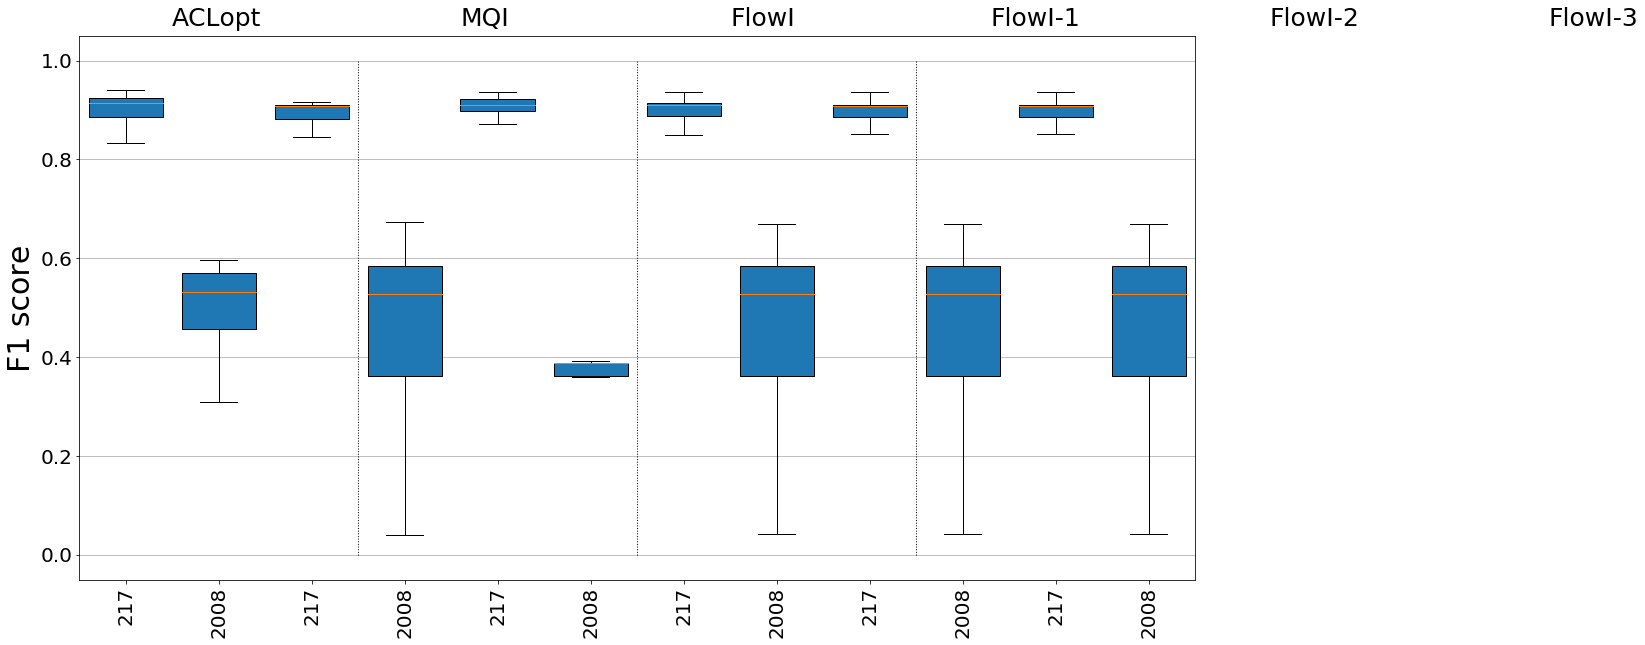

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_f1.png')

plt.show()

## Generate scatter plot for precision

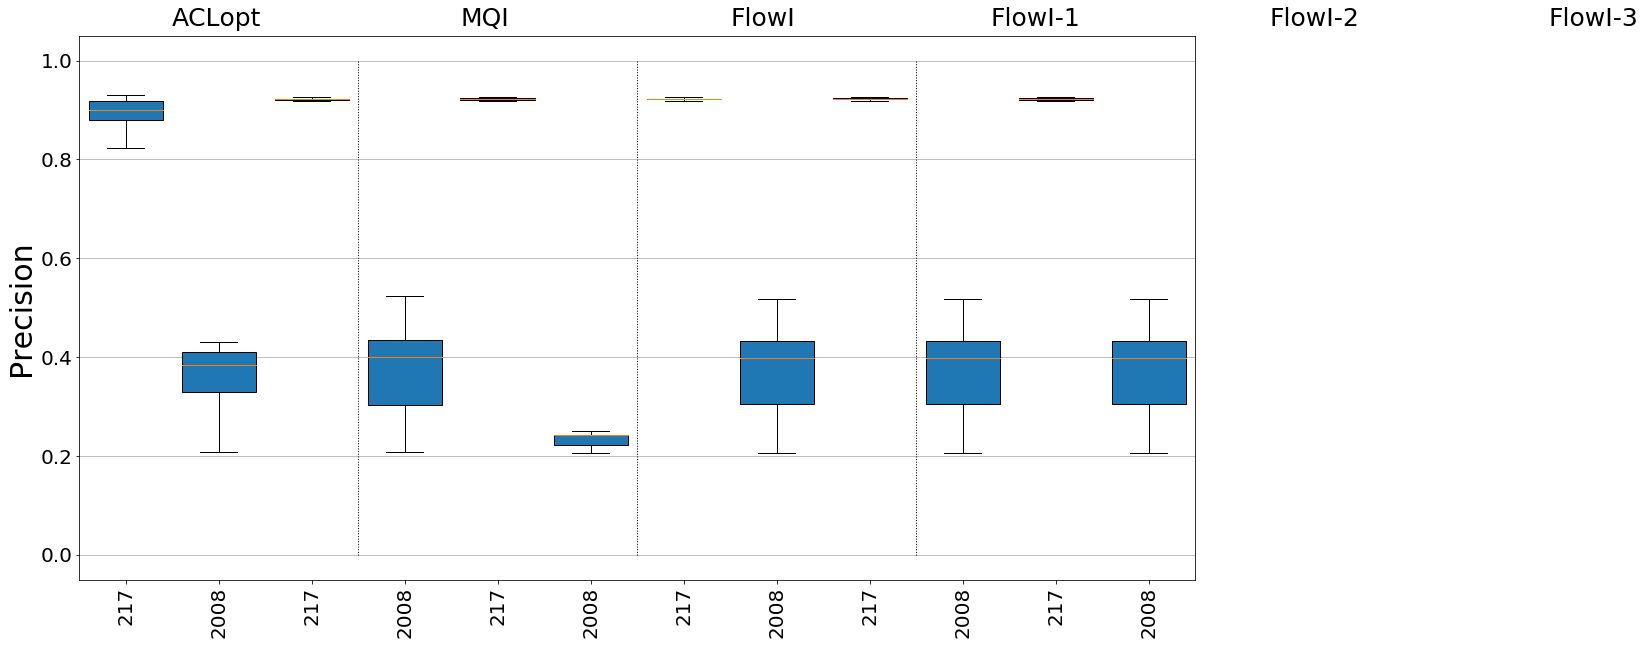

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_precision.png')

plt.show()

## Generate scatter plot for recall

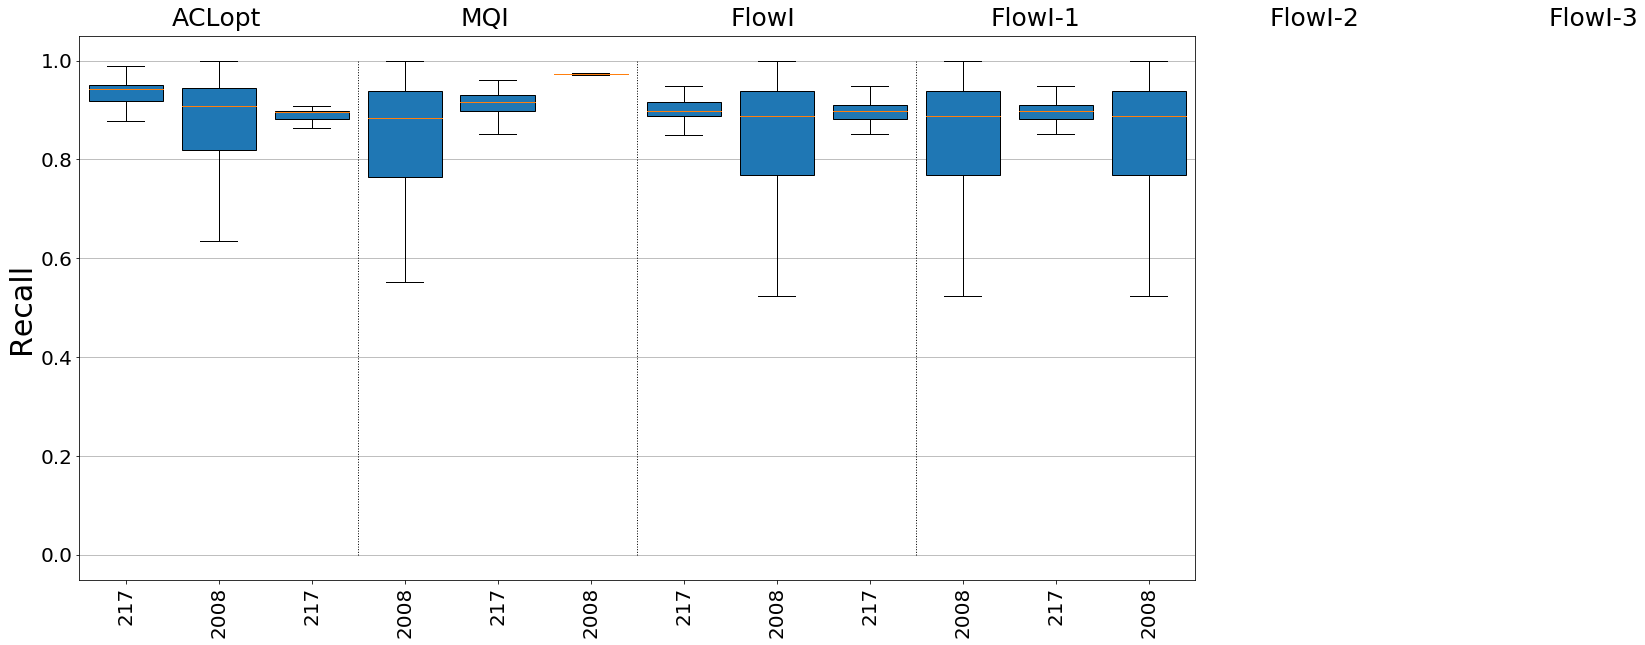

In [18]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_recall.png')

plt.show()

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 217.0 Precision 0.9011136644164661 Recall 0.9430628272251309 F1 0.914908285822976
Feature: 2008.0 Precision 0.38429313922578423 Recall 0.9091523378582202 F1 0.532207963658537
Results for MQI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8965033657442034 F1 0.9078441740782688
Feature: 2008.0 Precision 0.4004824419769363 Recall 0.8842171945701358 F1 0.5283507814006178
Results for FlowI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.9155759162303665 F1 0.9093751480411199
Feature: 2008.0 Precision 0.24209564826670638 Recall 0.972392156862745 F1 0.3876853427308675
Results for FlowI-1
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8973448017950636 F1 0.9093751480411199
Feature: 2008.0 Precision 0.39914729266532384 Recall 0.8882714932126696 F1 0.5287374638795587
Results for FlowI-2
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8973448017950636 F1 0.9089099526066351
Feature: 2008.0 Precision 0.39914729266532384 Recall 0.8882714932126696 F1 